In [48]:
import os
import pickle
import random
import logging
import argparse

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from timeit import default_timer as timer
from datetime import timedelta

from models import WordEncoder, Attention, TagEmbedding, WordDecoder, MSVED, KumaMSD
from dataset import MorphologyDatasetTask3, Vocabulary

from kumaraswamy import Kumaraswamy
from hard_kumaraswamy import StretchedAndRectifiedDistribution as HardKumaraswamy

from main import *

In [49]:
def plot_function(sample, actual, vocab):
    x_labels = list(vocab.idx_2_desc.values())

    fig, ax = plt.subplots()
    im = ax.imshow(torch.cat((sample, actual), 0))

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(['sample', 'actual'])

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    plt.show()


In [50]:
def test_kuma(language, model_id):
    '''
    Test function
    '''
    device         = torch.device('cpu')
    checkpoint     = torch.load('../models/{}-{}/model.pt'.format(language, model_id), map_location=device)

    config         = checkpoint['config']
    vocab          = checkpoint['vocab']

    test_loader, d = initialize_dataloader(run_type='test', language=config['language'], task='sup',
                                           vocab=vocab, batch_size=1, shuffle=True)
    idx_2_char     = d.idx_2_char

    model, kumaMSD = initialize_model(config)
    model.load_state_dict(checkpoint['model_state_dict'])
    kumaMSD.load_state_dict(checkpoint['kumaMSD_state_dict'])

    model.eval()
    kumaMSD.eval()
    for i_batch, sample_batched in enumerate(test_loader):

        with torch.no_grad():
            x_s = sample_batched['source_form'].to(device)
            x_t = sample_batched['target_form'].to(device)
            y_t = sample_batched['msd'].to(device)

            x_s = torch.transpose(x_s, 0, 1)
            x_t = torch.transpose(x_t, 0, 1)
            y_t = torch.transpose(y_t, 0, 1)

            x_t_p, _, _ = model(x_s, x_t, y_t)
            sample, _   = kumaMSD(x_t)
            actual      = torch.sum(y_t, 0)
            
            x_t_p       = x_t_p[1:].view(-1, x_t_p.shape[-1])

            outputs     = F.log_softmax(x_t_p, dim=1).type(torch.LongTensor)
            outputs     = torch.squeeze(outputs, 1)

            target_word = ''
            for i in outputs:
                p       = np.argmax(i, axis=0).detach().cpu().item()
                entity  = idx_2_char[p]

                if   entity == '<SOS>':
                    continue
                elif entity == '<PAD>' or entity == '<EOS>':
                    break

                target_word += idx_2_char[p]
            
        return target_word, sample_batched, sample, actual, vocab

Source          : ['hüzününü']
MSD             : ['pos=N,poss=PSS3S,case=ESS,num=PL']
Target          : ['hüzünlerinde']
Predicted target: ['hüzünlerinde']


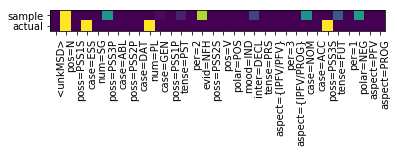

In [127]:
target_word, info, sample, actual, vocab = test_kuma('turkish', '16')

print('Source          : {}'.format(info['source_str']))
print('MSD             : {}'.format(info['msd_str']))
print('Target          : {}'.format(info['target_str']))
print("Predicted target: ['{}']".format(target_word))

plot_function(sample, actual, vocab)